In [ ]:

!pip install -q lightgbm imbalanced-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, accuracy_score, f1_score,
    precision_score, recall_score, auc, roc_curve
)
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTETomek


df = pd.read_csv('merged_billboard_spotify.csv')


audio_features = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence',
    'tempo', 'duration_ms'
]

df = df.dropna(subset=audio_features + ['is_hit'])
X = df[audio_features]
y = df['is_hit']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)
feature_names = poly.get_feature_names_out(audio_features)


X_train, X_temp, y_train, y_temp = train_test_split(X_poly, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train, y_train)



In [ ]:

model = LGBMClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.03,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_bal, y_train_bal)


probs = model.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.1, 0.9, 81)
metrics = []

for t in thresholds:
    preds_t = (probs > t).astype(int)
    prec_0 = precision_score(y_val, preds_t, pos_label=0)
    rec_0 = recall_score(y_val, preds_t, pos_label=0)
    prec_1 = precision_score(y_val, preds_t, pos_label=1)
    rec_1 = recall_score(y_val, preds_t, pos_label=1)
    f1_0 = f1_score(y_val, preds_t, pos_label=0)
    f1_1 = f1_score(y_val, preds_t, pos_label=1)
    macro_f1 = (f1_0 + f1_1) / 2
    metrics.append((t, prec_0, rec_0, prec_1, rec_1, f1_0, f1_1, macro_f1))

metrics_df = pd.DataFrame(metrics, columns=[
    'threshold', 'prec_0', 'rec_0', 'prec_1', 'rec_1', 'f1_0', 'f1_1', 'macro_f1'
])



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 292, number of negative: 292
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16705
[LightGBM] [Info] Number of data points in the train set: 584, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


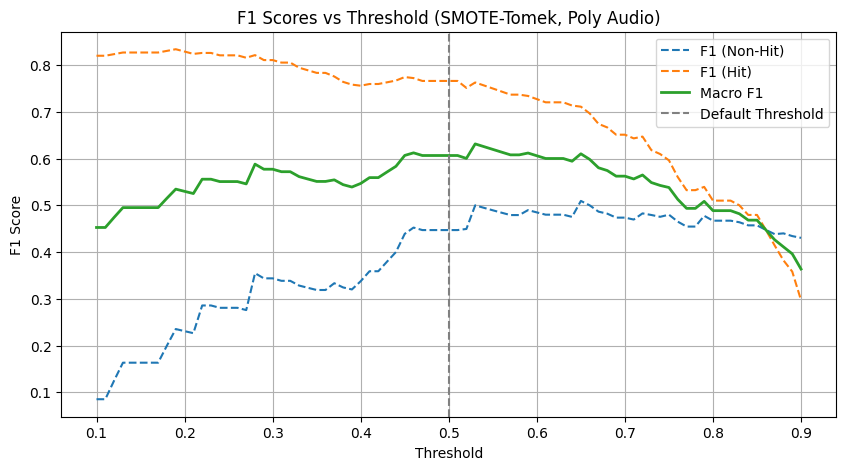


🎯 Best Threshold by Macro F1: 0.53

=== FINAL MODEL RESULTS (SMOTE-Tomek + Poly) ===
Accuracy     : 0.6783
F1 Score     : 0.7629
ROC AUC      : 0.6022
PR AUC       : 0.7162
              precision    recall  f1-score   support

           0       0.48      0.52      0.50        44
           1       0.78      0.75      0.76        99

    accuracy                           0.68       143
   macro avg       0.63      0.64      0.63       143
weighted avg       0.69      0.68      0.68       143



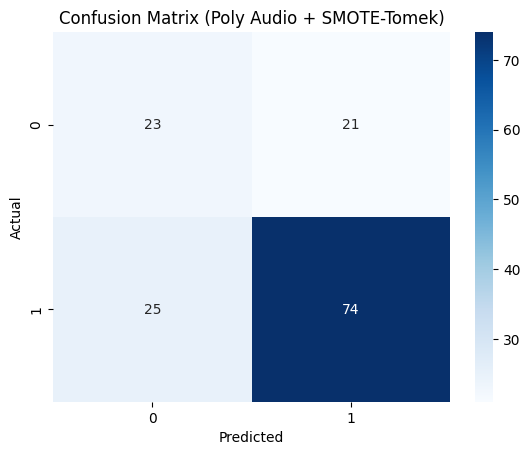

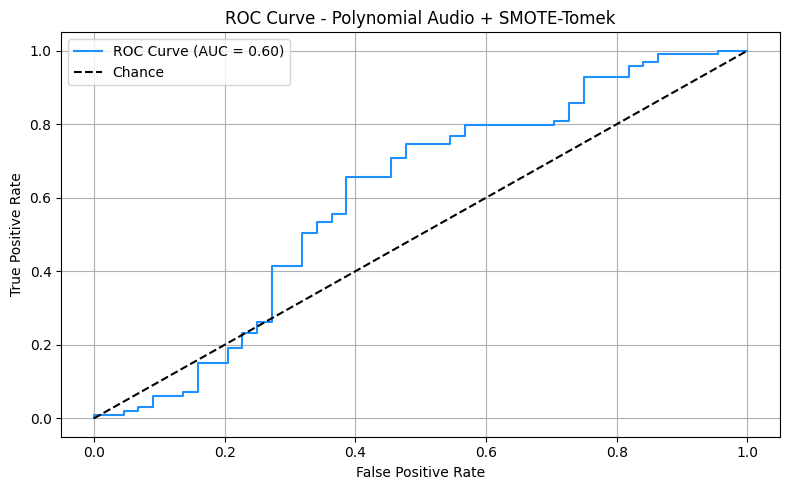

<ipython-input-28-abb4efa9a706>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances.values, y=top_importances.index, palette="viridis")


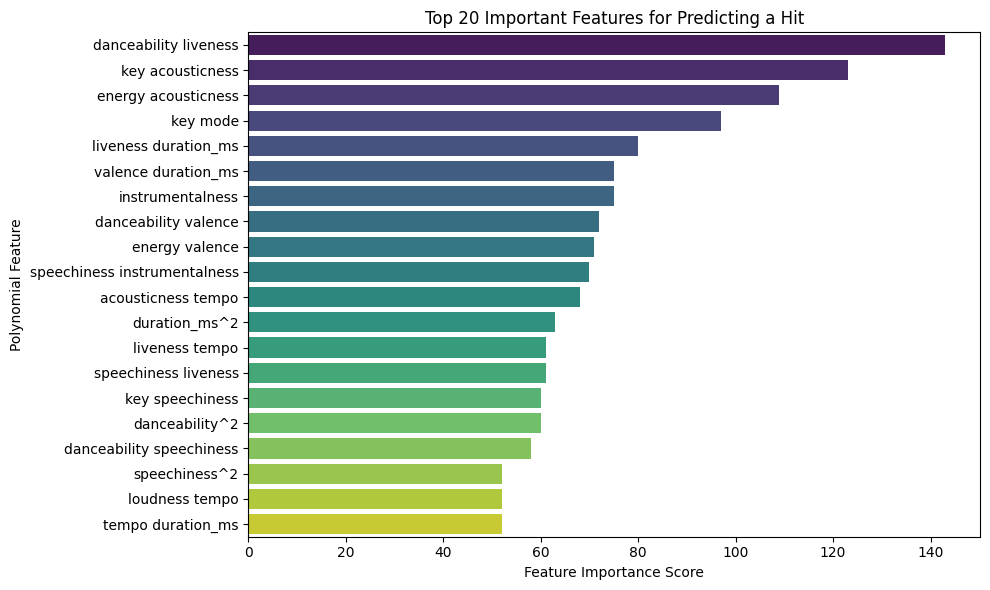

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(metrics_df['threshold'], metrics_df['f1_0'], label='F1 (Non-Hit)', linestyle='--')
plt.plot(metrics_df['threshold'], metrics_df['f1_1'], label='F1 (Hit)', linestyle='--')
plt.plot(metrics_df['threshold'], metrics_df['macro_f1'], label='Macro F1', linewidth=2)
plt.axvline(0.5, color='gray', linestyle='--', label='Default Threshold')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Scores vs Threshold (SMOTE-Tomek, Poly Audio)")
plt.legend()
plt.grid(True)
plt.show()


best_idx = metrics_df['macro_f1'].idxmax()
best_t = metrics_df.loc[best_idx, 'threshold']
print(f"\n🎯 Best Threshold by Macro F1: {best_t:.2f}")


final_preds = (probs > best_t).astype(int)
accuracy = accuracy_score(y_val, final_preds)
roc = roc_auc_score(y_val, probs)
precision, recall, _ = precision_recall_curve(y_val, probs)
pr_auc = auc(recall, precision)
f1 = f1_score(y_val, final_preds)
report = classification_report(y_val, final_preds)

print("\n=== FINAL MODEL RESULTS (SMOTE-Tomek + Poly) ===")
print(f"Accuracy     : {accuracy:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"ROC AUC      : {roc:.4f}")
print(f"PR AUC       : {pr_auc:.4f}")
print(report)


sns.heatmap(confusion_matrix(y_val, final_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Poly Audio + SMOTE-Tomek)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


fpr, tpr, _ = roc_curve(y_val, probs)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc:.2f})', color='dodgerblue')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Polynomial Audio + SMOTE-Tomek")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
top_importances = importances.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances.values, y=top_importances.index, palette="viridis")
plt.title("Top 20 Important Features for Predicting a Hit")
plt.xlabel("Feature Importance Score")
plt.ylabel("Polynomial Feature")
plt.tight_layout()
plt.show()
